In [119]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import ndtri
from scipy.stats import chi2
from scipy.stats import t
from scipy.stats import f
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import random
from scipy.stats import shapiro
from scipy.stats import bartlett
from scipy import stats


In [120]:
# Setting an appealing theme
sns.set_style("dark")  # Other options: "dark", "white", "ticks"
sns.set_context("notebook")  # Other options: "paper", "notebook", "talk", "poster"
sns.set_palette("bright")  # Other options: "deep", "muted", "bright", "dark", "colorblind"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [121]:
graph_df = pd.read_csv(r'../data/graph_properties.csv')
graph_df['graph_id'] = graph_df.index + 1
graph_df.head()

,Index,File,Nodes,NumLayers,NumEdges,EdgeDensity,AvgNodesPerLayer,AvgEdgesPerLayer,graph_id
0,0,north/g.10.72.graphml,12,6,13,0.520000,2.000000,2.600000,1
1,1,north/g.13.45.graphml,13,4,12,0.342857,3.250000,4.000000,2
2,2,north/g.10.11.graphml,10,5,14,1.000000,2.000000,3.500000,3
3,3,Rome-Lib/graficon11nodi/grafo233.11,18,8,19,0.475000,2.250000,2.714286,4
4,4,Rome-Lib/graficon12nodi/grafo2240.12,16,7,17,0.485714,2.285714,2.833333,5


In [122]:
df = pd.read_csv(r'../data/direct_transitivity_data.csv')
df.head()

,Index,File,Nodes,Total Nodes,Butterflies,X-vars,C-vars,Total vars,Total constraints,Crossings,...,config,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9
0,0,north/g.10.72.graphml,10,12,0,8,7,15,20,0,...,d_235689,0,1,1,0,1,1,0,1,1
1,1,north/g.13.45.graphml,13,13,0,6,2,8,8,0,...,d_235689,0,1,1,0,1,1,0,1,1
2,2,north/g.10.11.graphml,10,10,0,15,0,15,40,0,...,d_235689,0,1,1,0,1,1,0,1,1
3,3,Rome-Lib/graficon11nodi/grafo233.11,11,18,0,15,12,27,36,0,...,d_235689,0,1,1,0,1,1,0,1,1
4,4,Rome-Lib/graficon12nodi/grafo2240.12,12,16,0,12,11,23,30,0,...,d_235689,0,1,1,0,1,1,0,1,1


In [166]:
joined_df = df.merge(graph_df, on = 'File')
joined_df = joined_df[['graph_id','Total Nodes', 'Crossings','Opttime','Status','config', 'check_1', 'check_2',
       'check_3', 'check_4', 'check_5', 'check_6', 'check_7', 'check_8',
       'check_9' ]]

joined_df.head()

,graph_id,Total Nodes,Crossings,Opttime,Status,config,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9
0,1,12,0,0.000556,2,d_235689,0,1,1,0,1,1,0,1,1
1,1,12,0,0.000984,2,d_158,1,0,0,0,1,0,0,1,0
2,1,12,0,0.000857,2,d_1567,1,0,0,0,1,1,1,0,0
3,1,12,0,0.000621,2,d_234568,0,1,1,1,1,1,0,1,0
4,1,12,0,0.000661,2,d_58,0,0,0,0,1,0,0,1,0


In [167]:
joined_df['config'].replace('d_','d_0', inplace=True)
joined_df[joined_df['config'] == 'd_0']
joined_df['combination']=joined_df['config'].str.split('_').str[1]
joined_df['combination'] = joined_df['combination'].astype('category')
joined_df.head()

,graph_id,Total Nodes,Crossings,Opttime,Status,config,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9,combination
0,1,12,0,0.000556,2,d_235689,0,1,1,0,1,1,0,1,1,235689
1,1,12,0,0.000984,2,d_158,1,0,0,0,1,0,0,1,0,158
2,1,12,0,0.000857,2,d_1567,1,0,0,0,1,1,1,0,0,1567
3,1,12,0,0.000621,2,d_234568,0,1,1,1,1,1,0,1,0,234568
4,1,12,0,0.000661,2,d_58,0,0,0,0,1,0,0,1,0,58


In [168]:
cols_of_interest = ['graph_id','Total Nodes','Crossings', 'combination','Status','Opttime']
main_df = joined_df[cols_of_interest]

# Choosing Graph with 100% success 

In [169]:
def get_performance(main_df):
    main_df['performance_percantage'] = np.round(len(main_df[main_df['Status'] == 2])/len(main_df['Status']) * 100,2)
    return  main_df

main_df = main_df.groupby('graph_id').apply(get_performance)
main_df = main_df[combination_performance_status['performance_percantage'] == 100]

In [170]:
main_df['graph_id'].nunique()

593

In [171]:
np.random.seed(41)

sample_array = np.random.choice(main_df['graph_id'].unique(),200, replace = False)
sample_array

array([222, 250, 259, 530, 354, 316, 550, 523, 267, 722,  64, 559,  62,
       414, 191, 511, 300, 797, 348, 215, 116, 315, 392, 381, 702, 488,
       307, 413, 374,   4, 946,  59, 594, 140, 458, 219, 159, 281, 377,
       313, 895, 613, 721, 801, 120, 301, 391, 435, 318, 210, 531,  90,
       194, 111, 290, 297,  14, 416,  95, 446, 368,  71, 298, 224,  49,
       168, 512, 288, 791, 480, 390, 274, 213, 134, 228, 144,  23, 166,
       541, 678,  20, 138, 503, 243,  26, 295, 468, 681, 663, 171, 542,
       648, 593,  46, 326, 496, 533, 141,  43, 234,  17,  30, 306, 186,
       897, 909, 577, 331,  55, 195, 356, 344, 153, 282, 411, 614,  84,
       349, 509, 310, 528, 472,  21, 227, 178, 712, 538, 143,  83, 346,
        96, 216, 502,  57, 269, 660, 198, 599, 221, 556, 277,  50, 579,
       833, 223, 220, 192, 182,  37, 514,  61, 117, 119, 575, 260, 278,
        15, 406, 658, 419, 209, 126, 339, 521, 683, 333, 238, 887, 226,
       399, 464, 319, 302, 686, 293, 328, 631, 200, 125, 124, 26

In [172]:

main_df_sample = main_df[main_df['graph_id'].isin(sample_array)]
main_df_sample

,graph_id,Total Nodes,Crossings,combination,Status,Opttime,performance_percantage
0,1,12,0,235689,2,0.000556,100.0
1,1,12,0,158,2,0.000984,100.0
2,1,12,0,1567,2,0.000857,100.0
3,1,12,0,234568,2,0.000621,100.0
4,1,12,0,58,2,0.000661,100.0
...,...,...,...,...,...,...,...
484347,946,195,16,124679,2,2.698762,100.0
484348,946,195,16,14589,2,1.858571,100.0
484349,946,195,16,69,2,8.965483,100.0
484350,946,195,16,169,2,2.863193,100.0


In [173]:
main_df_sample['combination'].value_counts()

0        200
1        200
2479     200
24789    200
2478     200
        ... 
13567    200
1356     200
135      200
1349     200
9        200
Name: combination, Length: 512, dtype: int64

In [174]:
main_df_sample = main_df_sample[['combination','graph_id','Opttime']]
main_df_sample['graph_id'] = main_df_sample['graph_id'].astype('category')
main_df_sample.sort_values(by=['combination', 'graph_id'], inplace=True)
main_df_sample.shape

(102400, 3)

# Two Way Anova for Assumptions testing


In [175]:
# Performing two-way ANOVA 
model_2 = ols('Opttime ~ C(combination) + C(graph_id)', data=main_df_sample).fit() 


In [176]:

aov_table_2 = sm.stats.anova_lm(model_2, typ=2)
print(f"aov_table:\n {aov_table_2}")

aov_table:
                        sum_sq        df           F  PR(>F)
C(combination)   35623.958650     511.0   22.314826     0.0
C(graph_id)     486461.871351     199.0  782.470487     0.0
Residual        317688.679995  101689.0         NaN     NaN


# Testing Assumptions of Anova Model


### Normality

In [177]:
main_df_sample_model = main_df_sample.copy()
main_df_sample_model['residuals'] = model_2.resid
main_df_sample_model

,combination,graph_id,Opttime,residuals
409,0,1,0.001962,-0.166591
1945,0,4,0.000055,-0.171083
7065,0,14,0.012947,-0.157936
7577,0,15,0.000067,-0.165674
8601,0,17,0.000496,-0.165596
...,...,...,...,...
458898,9,897,1.819008,-0.642281
465042,9,909,9.611598,2.027802
473746,9,926,3.245096,0.308403
478354,9,935,3.236876,-0.096240


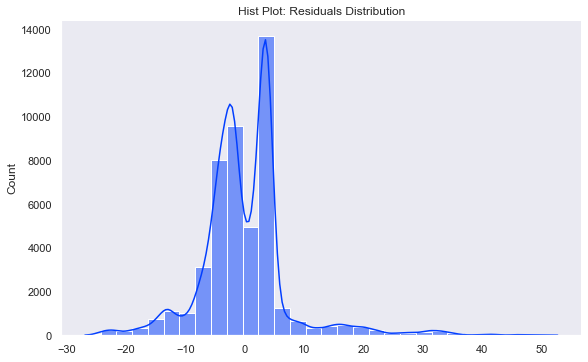

In [178]:

sns.displot(residuals, kde=True, aspect=10/6, bins = 30)
plt.title('Hist Plot: Residuals Distribution')
plt.show()


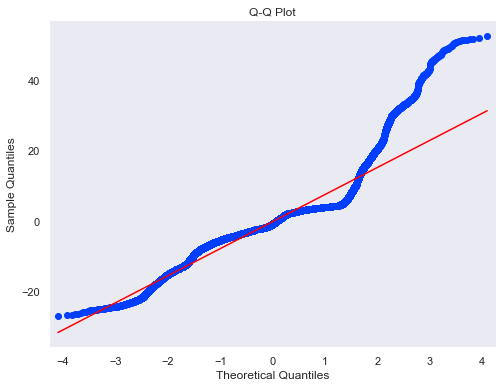

In [179]:
# Create Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)

# Add a straight diagonal line to the plot
ax.set_title('Q-Q Plot')
plt.show()

<AxesSubplot:xlabel='graph_id'>

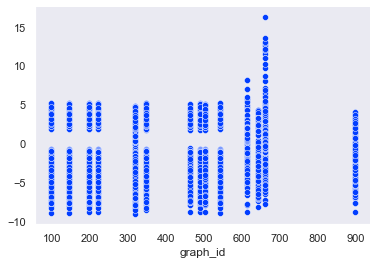

In [180]:
sns.scatterplot(x=main_df_sample_model['graph_id'], y = residuals)

<AxesSubplot:xlabel='combination'>

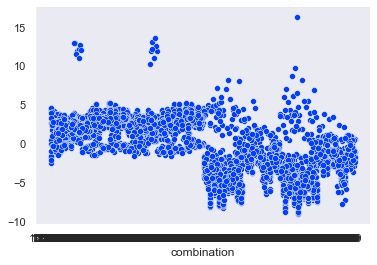

In [181]:
sns.scatterplot(x=main_df_sample_model['combination'], y = residuals)

In [182]:
opttime_data = main_df_sample_model['Opttime']

# Conduct the Shapiro-Wilk test
statistic, p_value = shapiro(opttime_data)

# Print the results
print("Shapiro-Wilk normality test:")
print(f"Statistic: {statistic}, p-value: {p_value}")

Shapiro-Wilk normality test:
Statistic: 0.42444783449172974, p-value: 0.0


# Equal Variance

In [185]:
main_df_sample_model['fitted_values'] = model_2.fittedvalues
sample_array = np.random.choice(main_df['combination'].unique(),50, replace = False)

main_df_sample_model_10 = main_df_sample_model[main_df_sample_model['combination'].isin(sample_array)]
main_df_sample_model_10

,combination,graph_id,Opttime,residuals,fitted_values
315,1234568,1,0.001142,0.564512,-0.563370
1851,1234568,4,0.002421,0.563207,-0.560785
6971,1234568,14,0.002463,0.563503,-0.561040
7483,1234568,15,0.000172,0.566354,-0.566182
8507,1234568,17,0.000330,0.566161,-0.565831
...,...,...,...,...,...
459261,69,897,1.766956,-0.534493,2.301449
465405,69,909,7.266632,-0.157325,7.423957
474109,69,926,3.197121,0.420268,2.776853
478717,69,935,3.358729,0.185453,3.173276


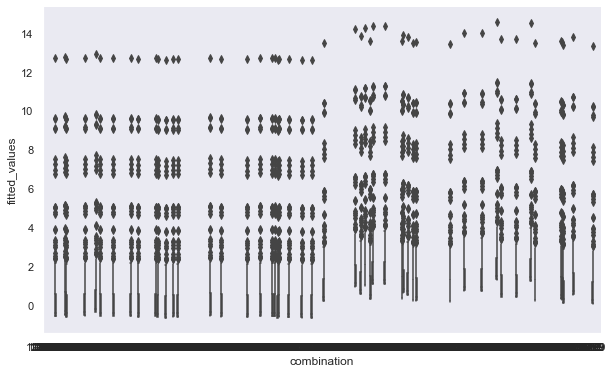

In [186]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='combination', y='fitted_values', data = main_df_sample_model_10)

plt.show()

# Trying with log transformation

In [189]:
main_df_sample_log = main_df_sample.copy()
main_df_sample_log['Opttime_log'] = np.log(main_df_sample_log['Opttime'])
main_df_sample_log

,combination,graph_id,Opttime,Opttime_log
409,0,1,0.001962,-6.233818
1945,0,4,0.000055,-9.811159
7065,0,14,0.012947,-4.346885
7577,0,15,0.000067,-9.610883
8601,0,17,0.000496,-7.609115
...,...,...,...,...
458898,9,897,1.819008,0.598291
465042,9,909,9.611598,2.262970
473746,9,926,3.245096,1.177145
478354,9,935,3.236876,1.174609


In [191]:
# Performing two-way ANOVA 
model_3 = ols('Opttime_log ~ C(combination) + C(graph_id)', data=main_df_sample_log).fit() 


In [192]:

aov_table_3 = sm.stats.anova_lm(model_3, typ=2)
print(f"aov_table:\n {aov_table_3}")

aov_table:
                        sum_sq        df            F  PR(>F)
C(combination)   12639.277829     511.0    60.494984     0.0
C(graph_id)     538095.694078     199.0  6613.394736     0.0
Residual         41577.270171  101689.0          NaN     NaN


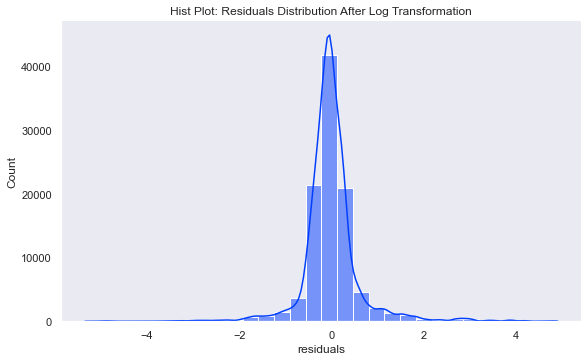

In [196]:

sns.displot(main_df_sample_log_model['residuals'], kde=True, aspect=10/6, bins = 30)
plt.title('Hist Plot: Residuals Distribution After Log Transformation')
plt.show()


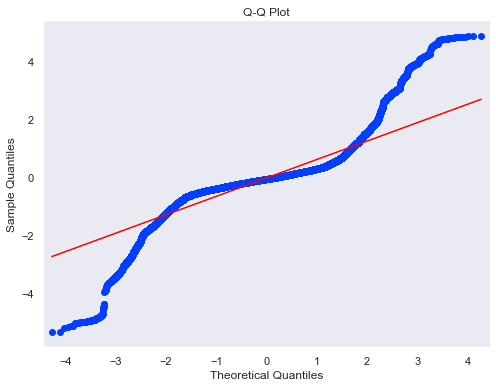

In [199]:
# Create Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(main_df_sample_log_model['residuals'], line='s', ax=ax)

# Add a straight diagonal line to the plot
ax.set_title('Q-Q Plot')
plt.show()

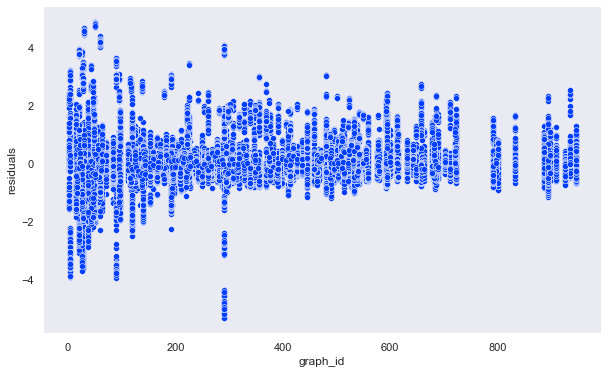

In [205]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='graph_id', y = 'residuals', data =main_df_sample_log_model)
plt.show()

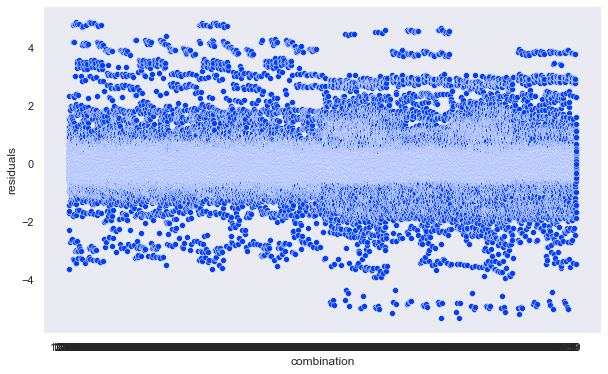

In [204]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='combination', y = 'residuals', data = main_df_sample_log_model)
plt.show()

In [202]:
sample_array = np.random.choice(main_df_sample_log_model['combination'].unique(),50, replace = False)

main_df_sample_log_model_10 = main_df_sample_log_model[main_df_sample_log_model['combination'].isin(sample_array)]
main_df_sample_log_model_10

,combination,graph_id,Opttime,Opttime_log,residuals,fitted_values
129,12,1,0.000970,-6.938085,-0.008445,-6.929640
1665,12,4,0.000077,-9.471586,-2.628320,-6.843266
6785,12,14,0.001469,-6.523081,-0.203332,-6.319749
7297,12,15,0.000091,-9.303817,0.392213,-9.696030
8321,12,17,0.000635,-7.362029,0.816202,-8.178232
...,...,...,...,...,...,...
459154,568,897,2.291532,0.829221,0.015110,0.814110
465298,568,909,6.257949,1.833853,-0.204223,2.038075
474002,568,926,4.037725,1.395681,0.263942,1.131739
478610,568,935,3.731758,1.316879,0.232587,1.084293


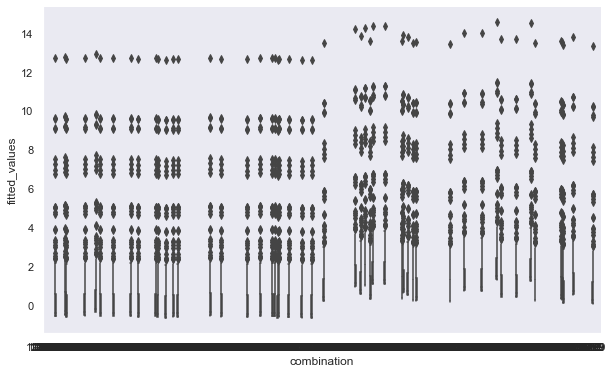

In [203]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='combination', y='fitted_values', data = main_df_sample_model_10)

plt.show()

In [165]:
statistic, p_value = bartlett(*[main_df_sample['Opttime'][main_df_sample['combination'] == combination] for combination in main_df_sample['combination'].unique()])
print(f"Bartlett's test statistic: {statistic}, p-value: {p_value}")

Bartlett's test statistic: 1154.2768967293307, p-value: 8.983167684758562e-243


In [15]:
combination_performance_status = main_df.groupby('graph_id').agg({'Status': lambda x: (x == 2).mean() * 100})
# combination_performance_characteristics = main_df[main_df['Status'] == 2].groupby('graph_id').agg({'Opttime': 'mean', 'Crossings':'mean', 'Total Nodes': 'mean'})

# combination_performance = pd.merge(combination_performance_status, 
#          combination_performance_characteristics, 
#          how='inner', 
#          left_index=True,
#          right_index=True
)

NameError: name 'combination_performance_characteristics' is not defined

In [16]:
combination_performance_status

,Status
graph_id,
1,100.000000
2,100.000000
3,100.000000
4,100.000000
5,100.000000
...,...
1146,0.000000
1147,0.000000
1148,1.953125


In [22]:
temp1 = combination_performance_status[(combination_performance_status['Status']== 100)].reset_index()
# temp = combination_performance_status[(combination_performance_status['Status']== 100) & (combination_performance['Crossings']!=0)].sort_values('Crossings', ascending=False).reset_index()
# plt.hist(temp['Opttime'])

temp1

,graph_id,Status
0,1,100.0
1,2,100.0
2,3,100.0
3,4,100.0
4,5,100.0
...,...,...
588,911,100.0
589,926,100.0
590,935,100.0
591,946,100.0


In [23]:
main_df_100 = main_df[(main_df['graph_id'].isin(temp1['graph_id'])) & (main_df['Crossings']!=0)]
main_df_100

,graph_id,Total Nodes,Crossings,combination,Status,Opttime
6144,13,13,1,235689,2,0.001178
6145,13,13,1,158,2,0.001124
6146,13,13,1,1567,2,0.000671
6147,13,13,1,234568,2,0.000877
6148,13,13,1,58,2,0.001314
...,...,...,...,...,...,...
507899,992,205,18,124679,2,4.227329
507900,992,205,18,14589,2,3.849955
507901,992,205,18,69,2,11.412050
507902,992,205,18,169,2,7.752419


## Sample 10

In [24]:
sample_array = np.random.choice(main_df_100['graph_id'].unique(),10)
main_df_sample = main_df_100[main_df_100['graph_id'].isin(sample_array)]
main_df_sample = main_df_sample[['combination','graph_id','Opttime']]
main_df_sample['graph_id'] = main_df_sample['graph_id'].astype('category')
main_df_sample.sort_values(by=['combination', 'graph_id'], inplace=True)
main_df_sample.head()

,combination,graph_id,Opttime
41369,0,81,0.028714
73113,0,143,0.044123
100249,0,196,0.037327
143769,0,281,0.426516
168857,0,330,0.378632


In [25]:
main_df_sample['combination'].value_counts()

0        10
1        10
2479     10
24789    10
2478     10
         ..
13567    10
1356     10
135      10
1349     10
9        10
Name: combination, Length: 512, dtype: int64

In [26]:
# Performing two-way ANOVA 
model_2 = ols('Opttime ~ C(combination) + C(graph_id)', data=main_df_sample).fit() 


In [27]:

aov_table_2 = sm.stats.anova_lm(model_2, typ=2)
print(f"aov_table:\n {aov_table_2}")

aov_table:
                      sum_sq      df            F        PR(>F)
C(combination)   900.307544   511.0     3.092184  4.402601e-88
C(graph_id)     5217.770723     9.0  1017.507874  0.000000e+00
Residual        2620.403151  4599.0          NaN           NaN


In [28]:
alpha = 0.05
df_a = aov_table_2['df'][0]
df_b = aov_table_2['df'][1]
df_ss = aov_table_2['df'][2]
critical_value = f.ppf(1-alpha, df_a, df_ss)

print(f"F Statististic for combination = {aov_table_2['F'][0]}")
print(f"Critical Value for F test is {critical_value}")
if(aov_table_2['F'][0] <= critical_value):
    print("Comclude Null Hypothesis")
else:
    print("Conclude Alternate")

F Statististic for combination = 3.092183694959794
Critical Value for F test is 1.1116264082359908
Conclude Alternate


## Sample 100

In [29]:
sample_array = np.random.choice(main_df_100['graph_id'].unique(),100, replace=False)
len(sample_array)

100

In [30]:

main_df_sample = main_df_100[main_df_100['graph_id'].isin(sample_array)]
main_df_sample = main_df_sample[['combination','graph_id','Opttime']]
main_df_sample['graph_id'] = main_df_sample['graph_id'].astype('category')
main_df_sample.sort_values(by=['combination', 'graph_id'], inplace=True)
main_df_sample.head()

,combination,graph_id,Opttime
9113,0,18,0.013712
13721,0,27,0.013340
21401,0,42,0.017893
22425,0,44,0.032727
24473,0,48,0.021751


In [31]:
main_df_sample['combination'].value_counts()

0        100
1        100
2479     100
24789    100
2478     100
        ... 
13567    100
1356     100
135      100
1349     100
9        100
Name: combination, Length: 512, dtype: int64

In [32]:
# Performing two-way ANOVA 
model_2 = ols('Opttime ~ C(combination) + C(graph_id)', data=main_df_sample).fit() 


In [33]:

aov_table_2 = sm.stats.anova_lm(model_2, typ=2)
print(f"aov_table:\n {aov_table_2}")

aov_table:
                        sum_sq       df           F  PR(>F)
C(combination)   18906.242119    511.0   13.068281     0.0
C(graph_id)     190671.977709     99.0  680.277048     0.0
Residual        143226.029638  50589.0         NaN     NaN


In [34]:
alpha = 0.05
df_a = aov_table_2['df'][0]
df_b = aov_table_2['df'][1]
df_ss = aov_table_2['df'][2]
critical_value = f.ppf(1-alpha, df_a, df_ss)

print(f"F Statististic for combination = {aov_table_2['F'][0]}")
print(f"Critical Value for F test is {critical_value}")
if(aov_table_2['F'][0] <= critical_value):
    print("Comclude Null Hypothesis")
else:
    print("Conclude Alternate")

F Statististic for combination = 13.068280776505466
Critical Value for F test is 1.1056875525331629
Conclude Alternate


## Try All sucess

In [35]:
# sample_array = np.random.choice(main_df_100['graph_id'].unique(),474, replace=False)
# main_df_sample = main_df_100[main_df_100['graph_id'].isin(sample_array)]
# main_df_sample = main_df_sample[['combination','graph_id','Opttime']]
# main_df_sample['graph_id'] = main_df_sample['graph_id'].astype('category')
# main_df_sample.sort_values(by=['combination', 'graph_id'], inplace=True)
# main_df_sample.head()

In [36]:
main_df_sample['combination'].value_counts()

0        100
1        100
2479     100
24789    100
2478     100
        ... 
13567    100
1356     100
135      100
1349     100
9        100
Name: combination, Length: 512, dtype: int64

In [37]:
# Performing two-way ANOVA 
model_2 = ols('Opttime ~ C(combination) + C(graph_id)', data=main_df_sample).fit() 


In [38]:

aov_table_2 = sm.stats.anova_lm(model_2, typ=2)
print(f"aov_table:\n {aov_table_2}")

aov_table:
                        sum_sq       df           F  PR(>F)
C(combination)   18906.242119    511.0   13.068281     0.0
C(graph_id)     190671.977709     99.0  680.277048     0.0
Residual        143226.029638  50589.0         NaN     NaN


In [39]:
alpha = 0.05
df_a = aov_table_2['df'][0]
df_b = aov_table_2['df'][1]
df_ss = aov_table_2['df'][2]
critical_value = f.ppf(1-alpha, df_a, df_ss)

print(f"F Statististic for combination = {aov_table_2['F'][0]}")
print(f"Critical Value for F test is {critical_value}")
if(aov_table_2['F'][0] <= critical_value):
    print("Comclude Null Hypothesis")
else:
    print("Conclude Alternate")

F Statististic for combination = 13.068280776505466
Critical Value for F test is 1.1056875525331629
Conclude Alternate


In [40]:
# Histogram
sns.displot(temp['Opttime'], kde=True, aspect=10/6)
plt.title('Hist Plot: Nodes vs Average Time')
plt.show()

NameError: name 'temp' is not defined

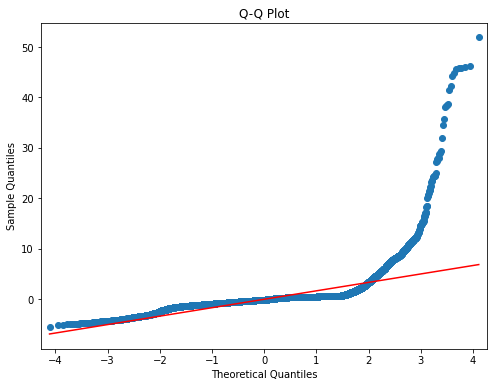

In [41]:
residuals = model_2.resid

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)

# Add a straight diagonal line to the plot
ax.set_title('Q-Q Plot')
plt.show()

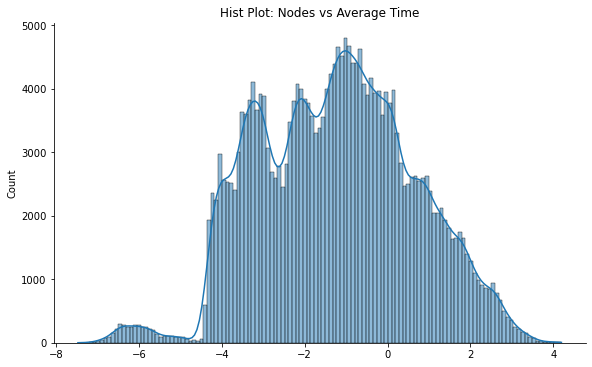

In [42]:
fitted_data_1, fitted_lambda_1 = stats.boxcox(main_df_100['Opttime'])
# Histogram
sns.displot(fitted_data_1, kde=True, aspect=10/6)
plt.title('Hist Plot: Nodes vs Average Time')
plt.show()

In [44]:
temp_transformed = main_df_100
temp_transformed['Opttime'] = fitted_data_1

temp_transformed

,graph_id,Total Nodes,Crossings,combination,Status,Opttime
6144,13,13,1,235689,2,-6.420087
6145,13,13,1,158,2,-6.462660
6146,13,13,1,1567,2,-6.927757
6147,13,13,1,234568,2,-6.686817
6148,13,13,1,58,2,-6.321143
...,...,...,...,...,...,...
507899,992,205,18,124679,2,1.456969
507900,992,205,18,14589,2,1.361521
507901,992,205,18,69,2,2.478809
507902,992,205,18,169,2,2.079178


In [45]:
transformed_df_100 = main_df[main_df['graph_id'].isin(temp_transformed['graph_id'])]
sample_array = np.random.choice(transformed_df_100['graph_id'].unique(),400, replace=False)

# transformed_df_sample = transformed_df_100[transformed_df_100['graph_id'].isin(sample_array)]
transformed_df_sample = transformed_df_100[['combination','graph_id','Opttime']]
transformed_df_sample['graph_id'] = transformed_df_sample['graph_id'].astype('category')
transformed_df_sample.sort_values(by=['combination', 'graph_id'], inplace=True)
transformed_df_sample.head()

,combination,graph_id,Opttime
6553,0,13,0.011049
7065,0,14,0.012947
9113,0,18,0.013712
10649,0,21,0.020972
11161,0,22,0.020437


In [46]:
# Performing two-way ANOVA 
model_2 = ols('Opttime ~ C(combination) + C(graph_id)', data=transformed_df_sample).fit() 


KeyboardInterrupt: 

In [ ]:

aov_table_2 = sm.stats.anova_lm(model_2, typ=2)
print(f"aov_table:\n {aov_table_2}")

aov_table:
                        sum_sq        df           F  PR(>F)
C(combination)   45777.689341     511.0   28.673817     0.0
C(graph_id)     390801.002239     199.0  628.572157     0.0
Residual        317703.082822  101689.0         NaN     NaN


In [ ]:
alpha = 0.05
df_a = aov_table_2['df'][0]
df_b = aov_table_2['df'][1]
df_ss = aov_table_2['df'][2]
critical_value = f.ppf(1-alpha, df_a, df_ss)

print(f"F Statististic for combination = {aov_table_2['F'][0]}")
print(f"Critical Value for F test is {critical_value}")
if(aov_table_2['F'][0] <= critical_value):
    print("Comclude Null Hypothesis")
else:
    print("Conclude Alternate")

F Statististic for combination = 28.673817383166163
Critical Value for F test is 1.1053828137872055
Conclude Alternate


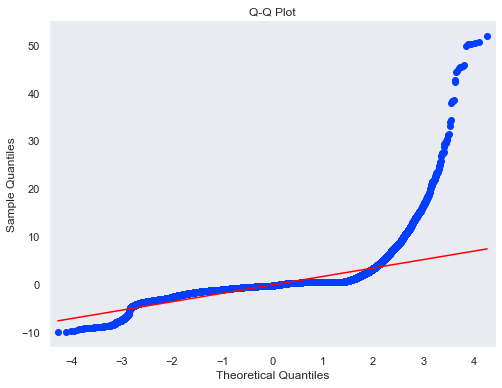

In [ ]:
residuals = model_2.resid

# Create Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(residuals, line='s', ax=ax)

# Add a straight diagonal line to the plot
ax.set_title('Q-Q Plot')
plt.show()

In [ ]:
fitted = model_2.fittedvalues

<AxesSubplot:>

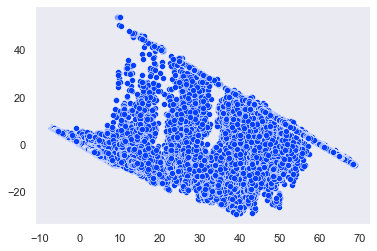

In [ ]:
sns.scatterplot(x=fitted, y=residuals)

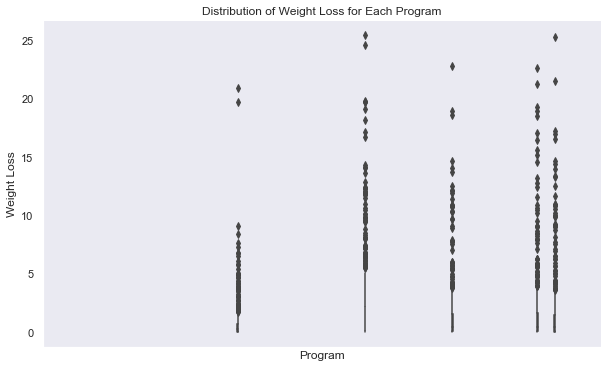

In [ ]:
sample_array = np.random.choice(main_df_100['combination'].unique(),5, replace=False)

main_df_100_sample = main_df_100[main_df_100['combination'].isin(sample_array)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='combination', y='Opttime', data=main_df_100_sample)
plt.xticks([])
plt.xlabel('Program')
plt.ylabel('Weight Loss')
plt.title('Distribution of Weight Loss for Each Program')
plt.show()

In [ ]:
statistic, p_value = bartlett(*[main_df_100['Opttime'][main_df_100['combination'] == combination] for combination in main_df_100['combination'].unique()])
print(f"Bartlett's test statistic: {statistic}, p-value: {p_value}")

Bartlett's test statistic: 133488.9032617315, p-value: 0.0
